# Project - Secondary Mushroom Dataset Analysis

In [46]:
# Import of all the necessary libraries
import urllib
import zipfile
import os

# Analysis libraries
from pyspark.sql.functions import count, when, isnan, col
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tabulate

import warnings

from collections import defaultdict

# All imports needed for the classification, evaluation and tuning
from pyspark.ml.feature import RFormula
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, DecisionTreeClassifier, GBTClassifier, NaiveBayes, LinearSVC, OneVsRest, MultilayerPerceptronClassifier, FMClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import PCA
from pyspark.mllib.evaluation import MulticlassMetrics

In [47]:
warnings.filterwarnings("ignore")

In [2]:
# We define the spark session and the spark context
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()
spark.stop()

spark = SparkSession.builder.master("spark://spark-master:7077").appName("BDA_Project").getOrCreate()
sc = spark.sparkContext

In [3]:
# All settings neeeded for logging and spark
sc.setLogLevel("ERROR")

In [4]:
# Defining the function to download and extract the file, it returns the path to the extracted file

def download_and_extract_file(url, destination) -> str:
    """
    Download and extract url to destination

    :param url: url to download
    :param destination: destination path

    :return: path to extracted file
    """
    urllib.request.urlretrieve(url, destination)
    with zipfile.ZipFile(destination, "r") as zip_ref:
        zip_ref.extractall("./data/")
    os.remove(destination)
    name = "./data/MushroomDataset.zip"
    with zipfile.ZipFile(name, "r") as zip_ref:
        zip_ref.extractall("./data/")
    os.listdir("./data/")
    os.remove(name)
    res = os.listdir("./data/")
    for i in res:
        if i == "MushroomDataset":
            return "./data/MushroomDataset/"
    return "./"

In [5]:
source = "https://archive.ics.uci.edu/static/public/848/secondary+mushroom+dataset.zip"
destination_zip = "./data/secondary+mushroom+dataset.zip"

datasets_path = download_and_extract_file(source, destination_zip)
print("Dataset downloaded and extracted to: " + datasets_path + "\n")

Dataset downloaded and extracted to: ./data/MushroomDataset/



### Transforming data from csv to DataFrame

In [6]:
import glob
for file in glob.glob("./data/MushroomDataset/*.csv"):
    if "secondary" in file:
        dataset_path = file

print("Dataset path: " + dataset_path + "\n")

Dataset path: ./data/MushroomDataset/secondary_data.csv



In [7]:
current_path = os.getcwd()
dataset_path = current_path + dataset_path[1:]
print("Dataset path: " + dataset_path + "\n")

Dataset path: /opt/spark/work-dir/data/MushroomDataset/secondary_data.csv



In [8]:
df = spark.read.format("csv").option("header", "true").option("inferSchema", "true").\
    option("sep", ";").load(dataset_path)
  
df.show(5)

+-----+------------+---------+-----------+---------+--------------------+---------------+------------+----------+-----------+----------+---------+------------+----------+---------+----------+--------+---------+-----------------+-------+------+
|class|cap-diameter|cap-shape|cap-surface|cap-color|does-bruise-or-bleed|gill-attachment|gill-spacing|gill-color|stem-height|stem-width|stem-root|stem-surface|stem-color|veil-type|veil-color|has-ring|ring-type|spore-print-color|habitat|season|
+-----+------------+---------+-----------+---------+--------------------+---------------+------------+----------+-----------+----------+---------+------------+----------+---------+----------+--------+---------+-----------------+-------+------+
|    p|       15.26|        x|          g|        o|                   f|              e|        NULL|         w|      16.95|     17.09|        s|           y|         w|        u|         w|       t|        g|             NULL|      d|     w|
|    p|        16.6|    

#### Visualization of the dataset structure

In [9]:
# We produce some statistics about the dataset
print("Number of rows: " + str(df.count()))
print("Number of columns: " + str(len(df.columns)))
print("Schema: ")
df.printSchema()

Number of rows: 61069
Number of columns: 21
Schema: 
root
 |-- class: string (nullable = true)
 |-- cap-diameter: double (nullable = true)
 |-- cap-shape: string (nullable = true)
 |-- cap-surface: string (nullable = true)
 |-- cap-color: string (nullable = true)
 |-- does-bruise-or-bleed: string (nullable = true)
 |-- gill-attachment: string (nullable = true)
 |-- gill-spacing: string (nullable = true)
 |-- gill-color: string (nullable = true)
 |-- stem-height: double (nullable = true)
 |-- stem-width: double (nullable = true)
 |-- stem-root: string (nullable = true)
 |-- stem-surface: string (nullable = true)
 |-- stem-color: string (nullable = true)
 |-- veil-type: string (nullable = true)
 |-- veil-color: string (nullable = true)
 |-- has-ring: string (nullable = true)
 |-- ring-type: string (nullable = true)
 |-- spore-print-color: string (nullable = true)
 |-- habitat: string (nullable = true)
 |-- season: string (nullable = true)



In [10]:
# We obtain a summary of the dataset
df.describe().show()

+-------+-----+-----------------+---------+-----------+---------+--------------------+---------------+------------+----------+------------------+------------------+---------+------------+----------+---------+----------+--------+---------+-----------------+-------+------+
|summary|class|     cap-diameter|cap-shape|cap-surface|cap-color|does-bruise-or-bleed|gill-attachment|gill-spacing|gill-color|       stem-height|        stem-width|stem-root|stem-surface|stem-color|veil-type|veil-color|has-ring|ring-type|spore-print-color|habitat|season|
+-------+-----+-----------------+---------+-----------+---------+--------------------+---------------+------------+----------+------------------+------------------+---------+------------+----------+---------+----------+--------+---------+-----------------+-------+------+
|  count|61069|            61069|    61069|      46949|    61069|               61069|          51185|       36006|     61069|             61069|             61069|     9531|       229

In [11]:
# We check the class distribution
df.groupBy("class").count().show()

+-----+-----+
|class|count|
+-----+-----+
|    e|27181|
|    p|33888|
+-----+-----+



In [12]:
# We check if there are any null values in the dataset
print("Number of null values in each column: ")
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

Number of null values in each column: 


+-----+------------+---------+-----------+---------+--------------------+---------------+------------+----------+-----------+----------+---------+------------+----------+---------+----------+--------+---------+-----------------+-------+------+
|class|cap-diameter|cap-shape|cap-surface|cap-color|does-bruise-or-bleed|gill-attachment|gill-spacing|gill-color|stem-height|stem-width|stem-root|stem-surface|stem-color|veil-type|veil-color|has-ring|ring-type|spore-print-color|habitat|season|
+-----+------------+---------+-----------+---------+--------------------+---------------+------------+----------+-----------+----------+---------+------------+----------+---------+----------+--------+---------+-----------------+-------+------+
|    0|           0|        0|      14120|        0|                   0|           9884|       25063|         0|          0|         0|    51538|       38124|         0|    57892|     53656|       0|     2471|            54715|      0|     0|
+-----+------------+----

## Categorical Analysis of the Dataset

This code segment is designed to perform a categorical analysis of a dataset. The process identifies and analyses columns in the dataset that contain categorical data, specifically those of string type. The process is divided as follows:
1. *Identification of Categorical Columns*
2. *Analysis of Unique Values in Categorical Columns*
3. *Tabulation of Analysis*

This analysis is crucial for understanding the composition of categorical variables in the dataset, aiding in further data exploration and preprocessing steps.


In [13]:
# We perform a categorical analysis of the dataset, checking the number of unique values in each column
# All columns with string type are considered categorical
categorical_columns = []
for column in df.columns:
    if str(df.schema[column].dataType) == "StringType()":
        categorical_columns.append(column)
print("Categorical analysis: ")
table = []
for column in categorical_columns:
    # We save the unique values in a list
    unique_values = df.select(column).distinct().collect()
    for i in range(len(unique_values)):
        unique_values[i] = unique_values[i][column]
    num_unique_values = len(unique_values)
    table.append([column, num_unique_values, unique_values])
print(tabulate.tabulate(table, headers=["Column", "Number of unique values", "Unique values"], tablefmt="orgtbl", numalign="center"))

Categorical analysis: 
| Column               |  Number of unique values  | Unique values                                                     |
|----------------------+---------------------------+-------------------------------------------------------------------|
| class                |             2             | ['e', 'p']                                                        |
| cap-shape            |             7             | ['x', 'f', 'o', 'p', 'c', 'b', 's']                               |
| cap-surface          |            12             | ['l', 'g', 'k', 'e', 'h', 'd', 'y', 'w', 'i', 't', 's', None]     |
| cap-color            |            12             | ['l', 'g', 'n', 'k', 'e', 'o', 'p', 'w', 'y', 'u', 'b', 'r']      |
| does-bruise-or-bleed |             2             | ['f', 't']                                                        |
| gill-attachment      |             8             | ['x', 'f', 'e', 'p', 'd', 'a', 's', None]                         |
| gill-sp

## Analysis of Numerical Columns in the Dataset

This part focuses on the analysis of numerical data within the dataset. The key steps involve identifying numerical columns, calculating summary statistics, and building a correlation matrix for these columns.
1. *Identification of Numerical Columns*
2. *Summary Statistics for Numerical Features*
3. *Correlation Analysis between Numerical Features*
4. *Displaying the Correlation Matrix*

These insights are valuable for data exploration, feature selection, and predictive modeling in data analysis and machine learning applications.


In [14]:
numerical_cols = [col for col in df.columns if col not in categorical_columns]

# Summary statistics for numerical features
df.select(numerical_cols).describe().show()

# Correlation between numerical features, we build a correlation matrix
correlation_matrix = defaultdict(dict)
for i in range(len(numerical_cols)):
    for j in range(len(numerical_cols)):
        if i != j:
            correlation_matrix[numerical_cols[i]][numerical_cols[j]] = df.stat.corr(numerical_cols[i], numerical_cols[j])

# We print the correlation matrix
print("Correlation matrix: ")
table = []
for key in correlation_matrix.keys():
    table.append([key, correlation_matrix[key]])
print(tabulate.tabulate(table, headers=["Column", "Correlation"], tablefmt="orgtbl", numalign="center"))

+-------+-----------------+------------------+------------------+
|summary|     cap-diameter|       stem-height|        stem-width|
+-------+-----------------+------------------+------------------+
|  count|            61069|             61069|             61069|
|   mean|6.733854492459317| 6.581538260001019|12.149410011626177|
| stddev|5.264844947062989|3.3700168612896366| 10.03595504311756|
|    min|             0.38|               0.0|               0.0|
|    max|            62.34|             33.92|            103.91|
+-------+-----------------+------------------+------------------+

Correlation matrix: 
| Column       | Correlation                                                             |
|--------------+-------------------------------------------------------------------------|
| cap-diameter | {'stem-height': 0.42256020778728226, 'stem-width': 0.6953296956538962}  |
| stem-height  | {'cap-diameter': 0.42256020778728226, 'stem-width': 0.4361165793454984} |
| stem-width   | {'c

## Visualization of the data

<Figure size 500x500 with 0 Axes>

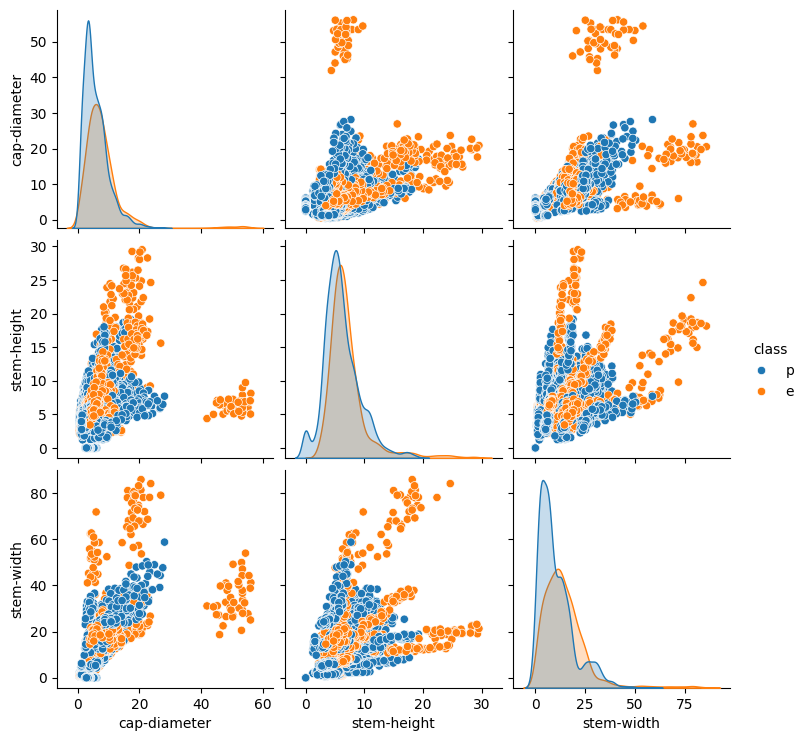

In [15]:
# Sample a fraction of your data for visualization
sample_df = df.sample(False, 0.1).toPandas()

# Pair plot for numerical features
plt.figure(figsize=(5, 5))
sns.pairplot(sample_df, vars=numerical_cols, hue='class')
plt.show()

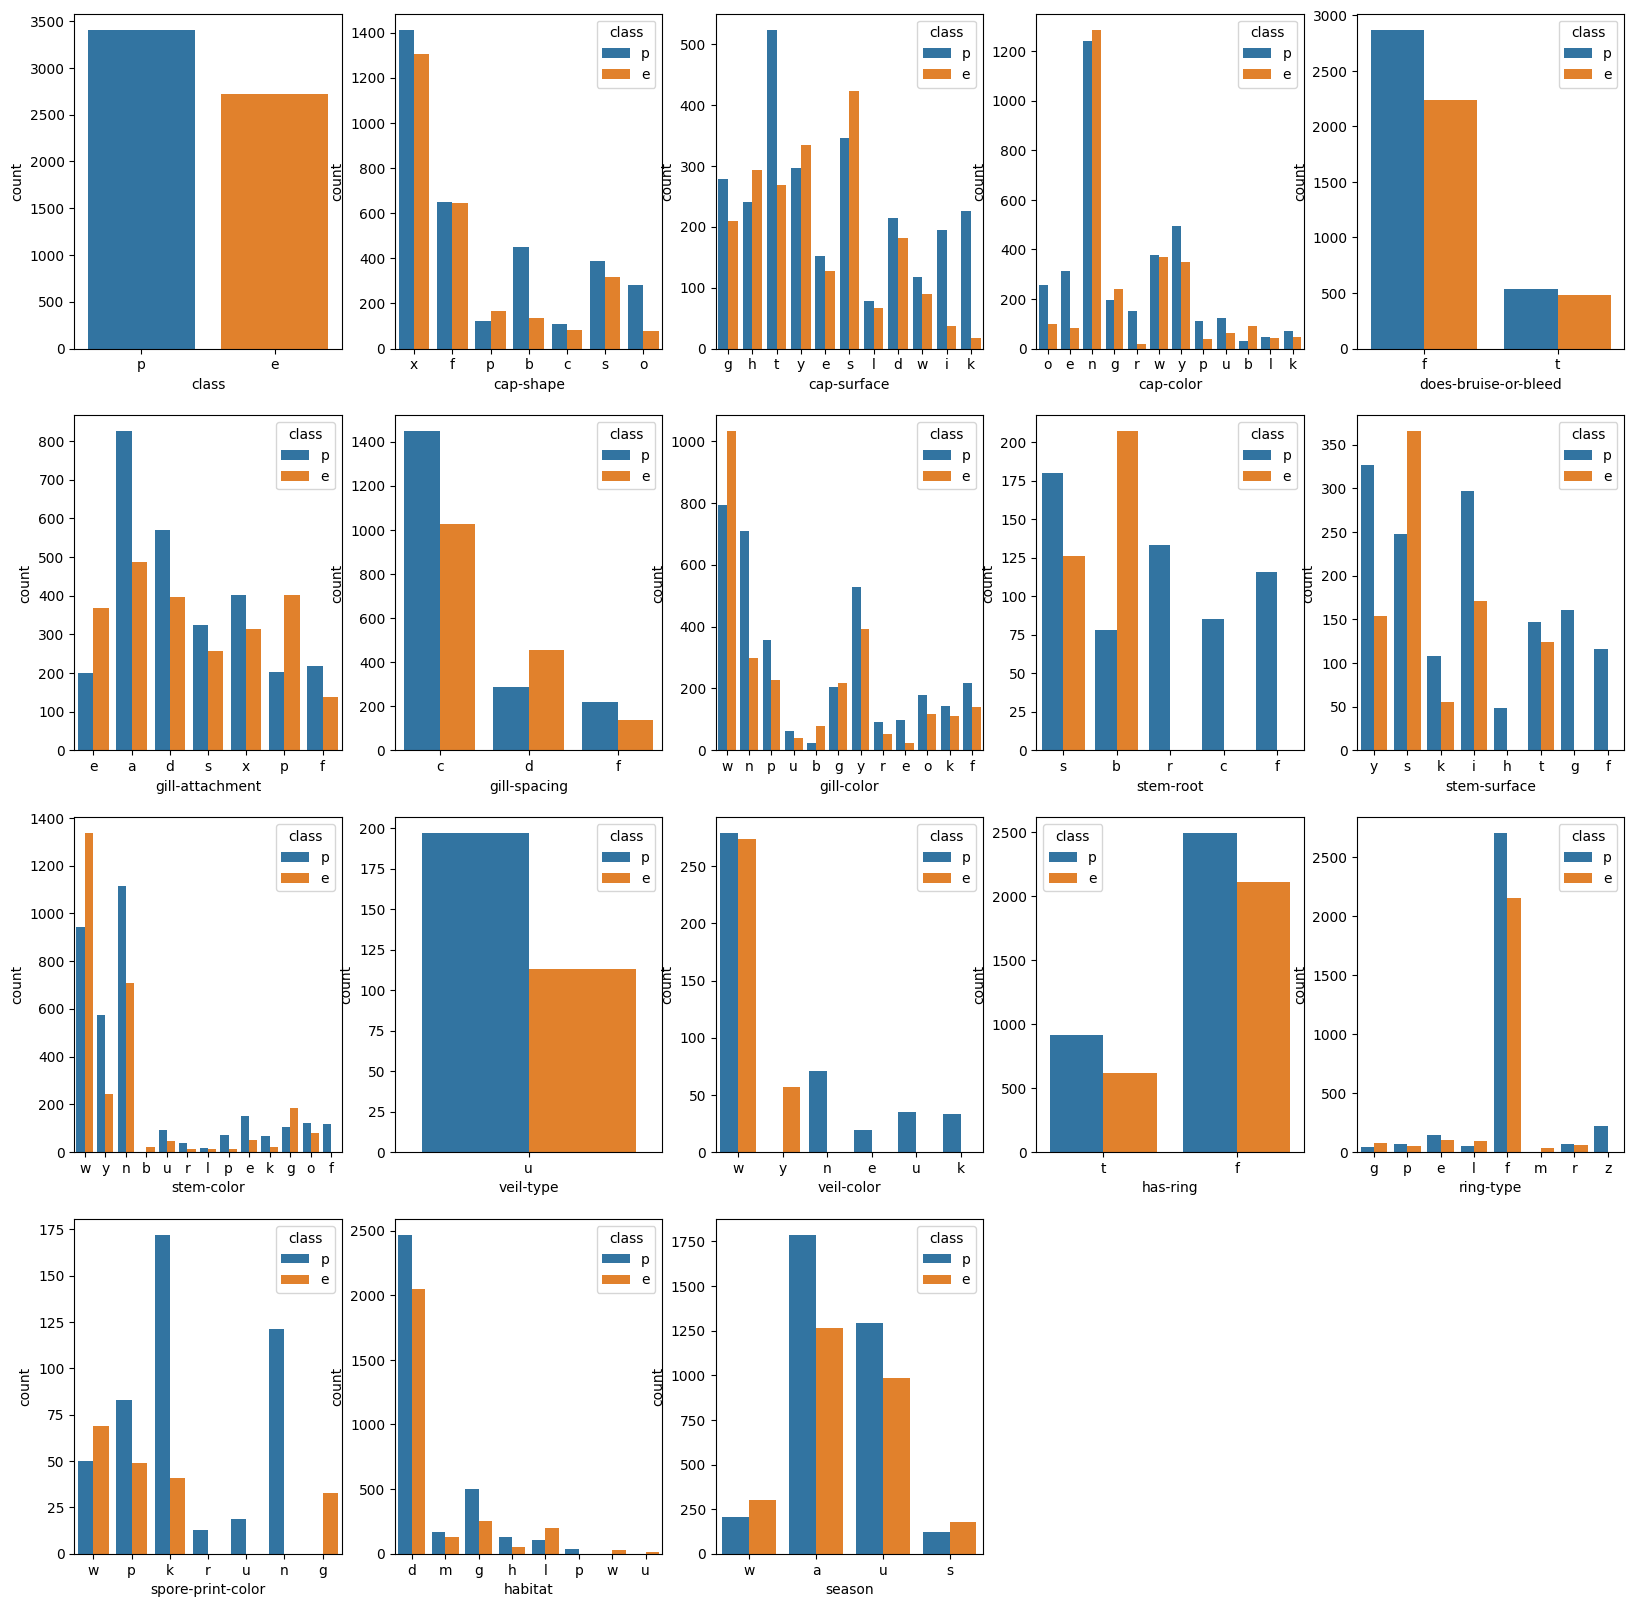

In [16]:
# Count plot for categorical features, we plot all in one figure, with subplots
plt.figure(figsize=(20, 20))
for i in range(len(categorical_columns)):
    plt.subplot(4, 5, i + 1)
    sns.countplot(x=categorical_columns[i], hue='class', data=sample_df)
plt.show()

### Processing of the dataset

Duplicates removal

In [17]:
# We remove duplicates from the dataset
print("Number of rows before removing duplicates: " + str(df.count()))
df = df.dropDuplicates()
print("Number of rows after removing duplicates: " + str(df.count()))

Number of rows before removing duplicates: 61069
Number of rows after removing duplicates: 60923


Taking inspiration from the paper we are following, our approach involves omitting columns where the count of null values exceeds half of the total number of rows. For the remaining columns, we will impute missing data using the mode, which is the most frequently occurring value in each column.

In [18]:
# We compute the number of null values in each column
null_values = df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).collect()[0]
null_values_dict = {}
for i in range(len(null_values)):
    if null_values[i] == 0:
        continue
    null_values_dict[null_values[i]] = df.columns[i]

null_values_dict = sorted(null_values_dict.items(), reverse=True)
print("Columns with null values: ")
for i in range(len(null_values_dict)):
    print(null_values_dict[i][1] + ": " + str(null_values_dict[i][0]))

Columns with null values: 
veil-type: 57746
spore-print-color: 54597
veil-color: 53510
stem-root: 51536
stem-surface: 38122
gill-spacing: 25062
cap-surface: 14120
gill-attachment: 9855
ring-type: 2471


In [19]:
# We delete the columns with a high number of null values, greater than 50% of the total number of rows
null_values_to_remove = []
for i in null_values_dict:
    if i[0] > df.count() / 2:
        null_values_to_remove.append(i[1])

df = df.drop(*null_values_to_remove)
print("Number of columns after removing columns with a high number of null values: " + str(len(df.columns)))

Number of columns after removing columns with a high number of null values: 16


In [20]:
# For all the other columns with a low number of null values, we replace the null values with the most frequent value of the column
for i in df.columns:
    if df.filter(df[i].isNull()).count() > 0:
        most_frequent_value = df.groupBy(i).count().orderBy("count", ascending=False).collect()
        if most_frequent_value[0][0] == None: # If the most frequent value is None, we take the second most frequent value
            most_frequent_value = most_frequent_value[1][0]
        else:
            most_frequent_value = most_frequent_value[0][0]
        print("Most frequent value of column " + i + ": " + str(most_frequent_value))
        df = df.fillna(most_frequent_value, subset=[i])

Most frequent value of column cap-surface: t
Most frequent value of column gill-attachment: a
Most frequent value of column gill-spacing: c
Most frequent value of column ring-type: f


In [21]:
# We check again if there are any null values in the dataset
null_values = df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).collect()[0]
null_values_dict = {}
for i in range(len(null_values)):
    if null_values[i] == 0:
        continue
    null_values_dict[null_values[i]] = df.columns[i]

print("Number of null values in each column: ")
if len(null_values_dict) == 0:
    print("No null values in the dataset")
else:
    for i in null_values_dict:
        print(i + ": " + str(null_values_dict[i]))

Number of null values in each column: 
No null values in the dataset


## Transformation of the data

In [22]:
# We used the Rformula to transform the data
formula = RFormula(formula="class ~ .") # We use all the columns except the class column as features
df_transformed = formula.fit(df).transform(df)
df_transformed.show(5)

+-----+------------+---------+-----------+---------+--------------------+---------------+------------+----------+-----------+----------+----------+--------+---------+-------+------+--------------------+-----+
|class|cap-diameter|cap-shape|cap-surface|cap-color|does-bruise-or-bleed|gill-attachment|gill-spacing|gill-color|stem-height|stem-width|stem-color|has-ring|ring-type|habitat|season|            features|label|
+-----+------------+---------+-----------+---------+--------------------+---------------+------------+----------+-----------+----------+----------+--------+---------+-------+------+--------------------+-----+
|    p|       13.82|        f|          h|        o|                   f|              e|           c|         w|      16.86|     17.14|         w|       t|        p|      d|     u|(80,[0,2,10,22,28...|  0.0|
|    p|       12.16|        x|          h|        e|                   f|              e|           c|         w|      17.46|     17.51|         w|       t|        

In [23]:
# We split the dataset into training and test set
train, test = df_transformed.randomSplit([0.8, 0.2], seed=42) # We use a seed to be able to reproduce the results
print("Number of rows in the training set: " + str(train.count()))
print("Number of rows in the test set: " + str(test.count()))

Number of rows in the training set: 48842
Number of rows in the test set: 12081


## Definition of the metrics

We define some functions to compute the *accuracy*, the *f1 score*, the *f2 score* and the *AUC* of our models.

In [24]:
# We perform a binary classification, so we consider the class 1 as the positive class
def compute_metrics(predictions):
    """
    Compute the accuracy, the f1 and the f2 score of a model

    :param predictions: predictions of the model

    :return: accuracy, f1, f2
    """
    tp = predictions.filter(predictions.label == 1).filter(predictions.prediction == 1).count()
    tn = predictions.filter(predictions.label == 0).filter(predictions.prediction == 0).count()
    fp = predictions.filter(predictions.label == 0).filter(predictions.prediction == 1).count()
    fn = predictions.filter(predictions.label == 1).filter(predictions.prediction == 0).count()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)
    f2 = 5 * precision * recall / (4 * precision + recall)
    return accuracy, f1, f2

# Define a function to compute the ROC curve of a model
def compute_roc(predictions):
    """
    Compute the ROC curve of a model

    :param predictions: predictions of the model

    :return: list of tuples (false positive rate, true positive rate)
    """
    evaluator = BinaryClassificationEvaluator()
    roc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
    return roc

class CurveMetrics(BinaryClassificationMetrics):
    """
        A class to compute the ROC curve of a model
    """
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        for row in rdd.collect(): # We collect the RDD to be able to iterate over it, collect() is not recommended for large RDDs
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)
    
def compute_roc_curve(predictions):
    """
    Compute the ROC curve of a model

    :param predictions: predictions of the model

    :return: list of tuples (false positive rate, true positive rate)
    """
    roc = CurveMetrics(predictions.select("rawPrediction", "label").rdd.map(lambda row: (float(row['rawPrediction'][1]), float(row['label']))))
    roc = roc.get_curve("roc")
    return roc

## Training and Tuning of the models

Gaussian Naive Bayes


In [25]:
# We define a Gaussian Naive Bayes classifier
nb = NaiveBayes(modelType="gaussian", labelCol="label", featuresCol="features")
# We define the evaluator, for binary classification we use the area under the ROC curve
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
# We define the parameter grid
paramGrid = ParamGridBuilder().addGrid(nb.smoothing, [0.0, 1.0]).build()
# We define the cross validator
cv = CrossValidator(estimator=nb, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=10)
# We train the model
model = cv.fit(train)
# We print the best model, we also print the parameters of the best model
print("The best model has smoothing parameter: ", model.bestModel._java_obj.getSmoothing())
# We make predictions on the test set
predictions_nb = model.bestModel.transform(test)

The best model has smoothing parameter:  1.0


Logistic Regression

In [26]:
# We define a Logistic Regression classifier
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
paramGrid = ParamGridBuilder().addGrid(lr.regParam, [0.0, 0.5, 1.0]).addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]).build()
cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=10)
model = cv.fit(train)
print("The best model has regularization parameter: ", model.bestModel._java_obj.getRegParam())
print("The best model has elastic net parameter: ", model.bestModel._java_obj.getElasticNetParam())
predictions_lr = model.transform(test)

The best model has regularization parameter:  0.0
The best model has elastic net parameter:  0.0


Linear Discriminant Analysis / PCA

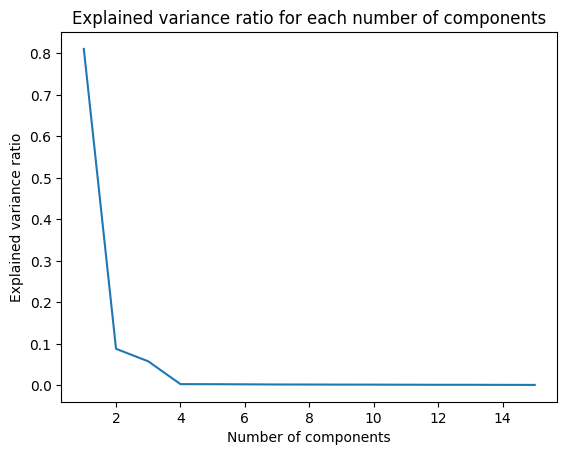

The best model has regularization parameter:  0.5
The best model has elastic net parameter:  0.0


In [33]:
# We perform PCA on the dataset and analyze the explained variance ratio to decide the number of components to keep
pca = PCA(k=15, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(df_transformed)
result = model.transform(df_transformed)

plt.plot(range(1, 16), model.explainedVariance.toArray())
plt.xlabel("Number of components")
plt.ylabel("Explained variance ratio")
plt.title("Explained variance ratio for each number of components")
plt.show()

# We keep 2 components
pca = PCA(k=2, inputCol="features", outputCol="pcaFeatures")
# We fit the PCA model
model = pca.fit(df_transformed)
# We transform the dataset
result = model.transform(df_transformed)

# We define a classifier using the PCA features
lr = LogisticRegression(labelCol="label", featuresCol="pcaFeatures", maxIter=10)
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
paramGrid = ParamGridBuilder().addGrid(lr.regParam, [0.0, 0.5, 1.0]).addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]).build()
cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=10)

# We split the dataset into training and test set
train_pca, test_pca = result.randomSplit([0.8, 0.2], seed=42)

model = cv.fit(train_pca)
print("The best model has regularization parameter: ", model.bestModel._java_obj.getRegParam())
print("The best model has elastic net parameter: ", model.bestModel._java_obj.getElasticNetParam())
predictions_lrpca = model.transform(test_pca)

Random Forest

In [34]:
# We define a Random Forest classifier
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=100)
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
paramGrid = ParamGridBuilder().addGrid(rf.maxDepth, [2, 5, 10]).addGrid(rf.maxBins, [10, 20, 40]).build()
cv = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=10)
model = cv.fit(train)
print("The best model has max depth: ", model.bestModel._java_obj.getMaxDepth())
print("The best model has max bins: ", model.bestModel._java_obj.getMaxBins())
predictions_rf = model.transform(test)

The best model has max depth:  10
The best model has max bins:  40


Decision Tree

In [35]:
# We now fit a Decision Tree model on the training set, using 10-fold cross validation
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
paramGrid = ParamGridBuilder().addGrid(dt.maxDepth, [2, 5, 10]).addGrid(dt.maxBins, [10, 20, 40]).build()
cv = CrossValidator(estimator=dt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=10)
model = cv.fit(train)
print("The best model has max depth: ", model.bestModel._java_obj.getMaxDepth())
print("The best model has max bins: ", model.bestModel._java_obj.getMaxBins())
predictions_dt = model.transform(test)

The best model has max depth:  10
The best model has max bins:  10


Gradient-Boosted Tree

In [36]:
# We fit a Gradient-Boosted Tree model on the training set
gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=50)
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
paramGrid = ParamGridBuilder().addGrid(gbt.maxDepth, [2, 5, 10]).addGrid(gbt.maxBins, [10, 20, 40]).build()
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=10)
model = cv.fit(train)
print("The best model has max depth: ", model.bestModel._java_obj.getMaxDepth())
print("The best model has max bins: ", model.bestModel._java_obj.getMaxBins())
predictions_gbt = model.transform(test)

The best model has max depth:  10
The best model has max bins:  20


One-vs-Rest

In [37]:
# We fit a One-vs-Rest Naive Bayes model on the training set
nb2 = NaiveBayes(modelType="gaussian", labelCol="label", featuresCol="features")
ovr = OneVsRest(classifier=nb2)
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
paramGrid = ParamGridBuilder().addGrid(nb2.smoothing, [0.0, 1.0]).build()
cv = CrossValidator(estimator=ovr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=10)
model = cv.fit(train)
for model in model.bestModel.models:
    print("The best model has smoothing parameter: ", model._java_obj.getSmoothing())
predictions_ovr = model.transform(test)

The best model has smoothing parameter:  1.0
The best model has smoothing parameter:  1.0


Evaluation of the models

In [38]:
predictions = [predictions_nb, predictions_lr, predictions_lrpca, predictions_rf, predictions_dt, predictions_gbt, predictions_ovr]
names = ["Gaussian Naive Bayes", "Logistic Regression", "Logistic Regression with PCA", "Random Forest", "Decision Tree", "Gradient Boosted Tree", "One-vs-Rest GNB"]
evaluations = []
for i in range(len(predictions)):
    accuracy, f1, f2 = compute_metrics(predictions[i])
    roc = compute_roc(predictions[i])
    el = {"accuracy": accuracy, "f1": f1, "f2": f2, "roc": roc}
    evaluations.append(el)

# We print the results
headers = ["Classifier", "Accuracy", "F1", "F2", "ROC"]
table = []
for i in range(len(predictions)):
    table.append([names[i], evaluations[i]["accuracy"], evaluations[i]["f1"], evaluations[i]["f2"], evaluations[i]["roc"]])


print(tabulate.tabulate(table, headers=headers, tablefmt="github"))

| Classifier                   |   Accuracy |       F1 |        F2 |      ROC |
|------------------------------|------------|----------|-----------|----------|
| Gaussian Naive Bayes         |   0.625114 | 0.693344 | 0.829687  | 0.691134 |
| Logistic Regression          |   0.77535  | 0.752913 | 0.763761  | 0.849208 |
| Logistic Regression with PCA |   0.557984 | 0.122288 | 0.0838972 | 0.63108  |
| Random Forest                |   0.968132 | 0.96384  | 0.959675  | 0.997044 |
| Decision Tree                |   0.90423  | 0.899939 | 0.940902  | 0.878202 |
| Gradient Boosted Tree        |   0.998179 | 0.997949 | 0.997949  | 0.999964 |
| One-vs-Rest GNB              |   0.625114 | 0.693344 | 0.829687  | 0.691129 |


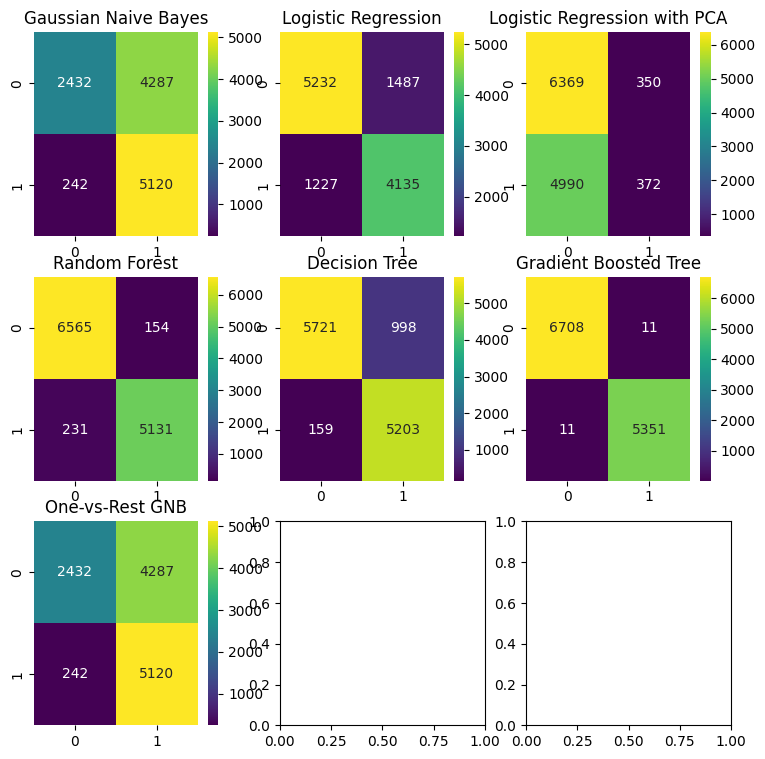

In [109]:
def plot_confusion_matrices(*preds):
    num_pred = len(preds)
    i = num_pred // 3 + 1 if num_pred % 3 != 0 else num_pred // 3
    fig, axs = plt.subplots(i, 3, figsize=(9, 3 * i))

    for i, pred in enumerate(preds):
        pred_labels = pred.select("prediction", "label").rdd
        cm = MulticlassMetrics(pred_labels).confusionMatrix().toArray().astype(int)
        df_cm = pd.DataFrame(cm, index = [i for i in "01"], columns = [i for i in "01"])
        # if axs is monodimensional
        if num_pred < 4:
            sns.heatmap(df_cm, annot=True, fmt='g', ax=axs[i % 3], cmap='viridis')
            axs[i % 3].set_title(names[i])
        else:
        # Plot the confusion matrix
            sns.heatmap(df_cm, annot=True, fmt='g', ax=axs[i // 3, i % 3], cmap='viridis')
            axs[i // 3, i % 3].set_title(names[i])
    plt.show()

plot_confusion_matrices(predictions_nb, predictions_lr, predictions_lrpca, predictions_rf, predictions_dt, predictions_gbt, predictions_ovr)

# Project Work - 3 CFU
As an intergation to our project we proposed three more methods.

MultiLayer Perceptron

In [50]:
# We fit a Multilayer Perceptron model on the training set
layers = [80, 5, 4, 2]
mp = MultilayerPerceptronClassifier(maxIter=100, layers=layers, featuresCol="features", labelCol="label")
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
paramGrid = ParamGridBuilder().addGrid(mp.blockSize, [128, 256]).build()
cv = CrossValidator(estimator=mp, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=10)
model = cv.fit(train)
print("The best model has block size: ", model.bestModel._java_obj.getBlockSize())
predictions_mp = model.transform(test)

The best model has block size:  256


Linear Support Vector Machine

In [51]:
# We fit a Linear Support Vector Machine model on the training set
lsvc = LinearSVC(maxIter=50, regParam=0.1)
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
paramGrid = ParamGridBuilder().addGrid(lsvc.maxIter, [50, 100]).build()
cv = CrossValidator(estimator=lsvc, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=10)
model = cv.fit(train)
print("The best model has max iterations: ", model.bestModel._java_obj.getMaxIter())
predictions_lsvc = model.transform(test)

The best model has max iterations:  100


Factorization Machines

In [52]:
# We fit a Factorization Machines model on the training set
fm = FMClassifier(labelCol="label", featuresCol="features")
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
paramGrid = ParamGridBuilder().addGrid(fm.maxIter, [10, 100]).build()
cv = CrossValidator(estimator=fm, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=10)
model = cv.fit(train)
print("The best model has max iterations: ", model.bestModel._java_obj.getMaxIter())
predictions_fm = model.transform(test)

The best model has max iterations:  100


Evaluation of the three models

In [84]:
predictions = [predictions_mp, predictions_lsvc, predictions_fm]
names = ["Multilayer Perceptron", "Linear SVM", "Factorization Machines"]
evaluations = []
for i in range(len(predictions)):
    accuracy, f1, f2 = compute_metrics(predictions[i])
    roc = compute_roc(predictions[i])
    el = {"accuracy": accuracy, "f1": f1, "f2": f2, "roc": roc}
    evaluations.append(el)

# We print the results
headers = ["Classifier", "Accuracy", "F1", "F2", "ROC"]
table = []
for i in range(len(predictions)):
    table.append([names[i], evaluations[i]["accuracy"], evaluations[i]["f1"], evaluations[i]["f2"], evaluations[i]["roc"]])

print(tabulate.tabulate(table, headers=headers, tablefmt="github"))

| Classifier             |   Accuracy |       F1 |       F2 |      ROC |
|------------------------|------------|----------|----------|----------|
| Multilayer Perceptron  |   0.785614 | 0.793527 | 0.869193 | 0.829603 |
| Linear SVM             |   0.781641 | 0.762428 | 0.778411 | 0.838111 |
| Factorization Machines |   0.961841 | 0.956872 | 0.954995 | 0.993065 |


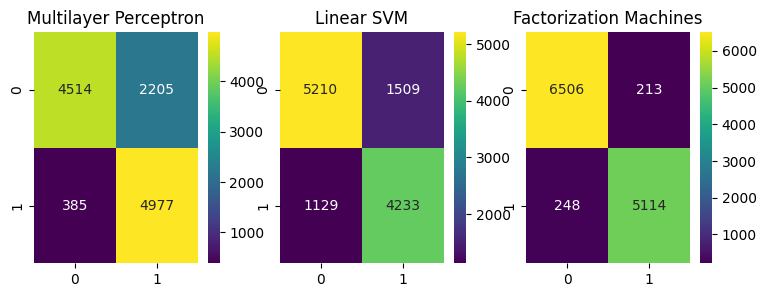

In [111]:
plot_confusion_matrices(predictions_mp, predictions_lsvc, predictions_fm)

## Results visualization

ROC curves of all models

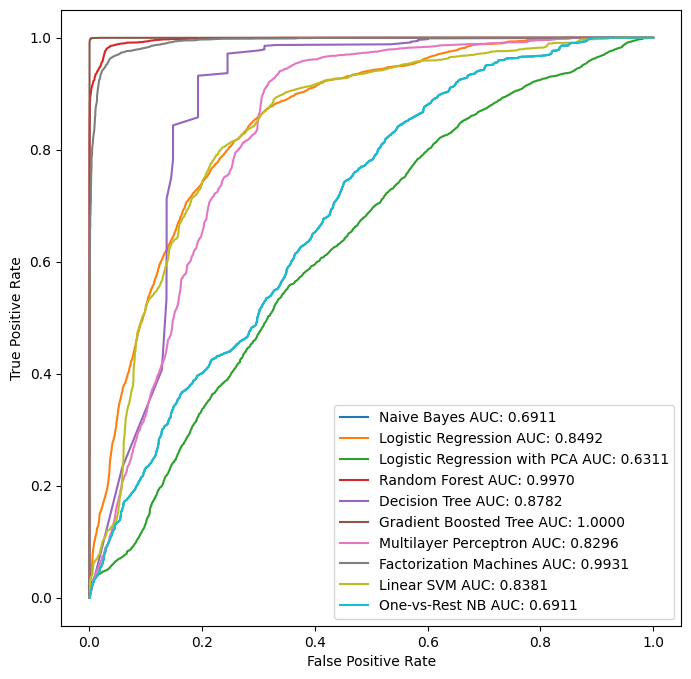

In [112]:
# We plot the ROC curve of the models
roc_nb = compute_roc_curve(predictions_nb)
roc_lr = compute_roc_curve(predictions_lr)
roc_lrpca = compute_roc_curve(predictions_lrpca)
roc_rf = compute_roc_curve(predictions_rf)
roc_dt = compute_roc_curve(predictions_dt)
roc_gbt = compute_roc_curve(predictions_gbt)
roc_mp = compute_roc_curve(predictions_mp)
roc_fm = compute_roc_curve(predictions_fm)
roc_lsvc = compute_roc_curve(predictions_lsvc)
roc_ovr = compute_roc_curve(predictions_ovr)

plt.figure(figsize=(8, 8))
plt.plot([x[0] for x in roc_nb], [x[1] for x in roc_nb], label=f"Naive Bayes AUC: {compute_roc(predictions_nb):.4f}")
plt.plot([x[0] for x in roc_lr], [x[1] for x in roc_lr], label=f"Logistic Regression AUC: {compute_roc(predictions_lr):.4f}")
plt.plot([x[0] for x in roc_lrpca], [x[1] for x in roc_lrpca], label=f"Logistic Regression with PCA AUC: {compute_roc(predictions_lrpca):.4f}")
plt.plot([x[0] for x in roc_rf], [x[1] for x in roc_rf], label=f"Random Forest AUC: {compute_roc(predictions_rf):.4f}")
plt.plot([x[0] for x in roc_dt], [x[1] for x in roc_dt], label=f"Decision Tree AUC: {compute_roc(predictions_dt):.4f}")
plt.plot([x[0] for x in roc_gbt], [x[1] for x in roc_gbt], label=f"Gradient Boosted Tree AUC: {compute_roc(predictions_gbt):.4f}")
plt.plot([x[0] for x in roc_mp], [x[1] for x in roc_mp], label=f"Multilayer Perceptron AUC: {compute_roc(predictions_mp):.4f}")
plt.plot([x[0] for x in roc_fm], [x[1] for x in roc_fm], label=f"Factorization Machines AUC: {compute_roc(predictions_fm):.4f}")
plt.plot([x[0] for x in roc_lsvc], [x[1] for x in roc_lsvc], label=f"Linear SVM AUC: {compute_roc(predictions_lsvc):.4f}")
plt.plot([x[0] for x in roc_ovr], [x[1] for x in roc_ovr], label=f"One-vs-Rest NB AUC: {compute_roc(predictions_ovr):.4f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

## Aggregation of Feature Importances in Transformed Dataframe

This code segment is dedicated to evaluating and aggregating the importance of features in a transformed dataframe, `df_transformed`. This dataframe is assumed to be the result of an `RFormula` transformation, commonly used in machine learning preprocessing.
1. *Extraction of Feature Schema*
2. *Combination of Different Feature Types*
3. *Organization of Features by Original Name*
4. *Aggregation of Feature Importances*
5. *Displaying Aggregated Importances*

This analysis is crucial for understanding the impact of each feature on the model's predictions, guiding feature selection and model refinement in machine learning workflows.

In [113]:
# Assuming df_transformed is the result of an RFormula transformation
schema = df_transformed.schema["features"].metadata["ml_attr"]["attrs"]

# Combine different feature types
all_features = schema.get('binary', []) + schema.get('numeric', [])

# Organize features by original feature name
feature_groups = defaultdict(list)
for feature in all_features:
    original_feature_name = feature['name'].split('_')[0]  # Assumes default naming convention used by one-hot encoding
    feature_groups[original_feature_name].append(feature['idx'])

In [114]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=100, maxBins=40, maxDepth=10)
model = rf.fit(train)
featureImportances = model.featureImportances

# Aggregated importance by original feature
aggregated_importances = defaultdict(float)
for original_feature, indices in feature_groups.items():
    aggregated_importance = sum(featureImportances[idx] for idx in indices)
    aggregated_importances[original_feature] = aggregated_importance

In [115]:
# Print using tabulate for pretty output
table = []
for feature, importance in aggregated_importances.items():
    table.append([feature, importance])
print(tabulate.tabulate(table, headers=["Original Feature", "Aggregated Importance"], tablefmt="orgtbl", numalign="center"))

| Original Feature     |  Aggregated Importance  |
|----------------------+-------------------------|
| cap-shape            |        0.0637802        |
| cap-surface          |        0.112812         |
| cap-color            |        0.0705041        |
| does-bruise-or-bleed |        0.0224287        |
| gill-attachment      |        0.112093         |
| gill-spacing         |        0.0691533        |
| gill-color           |        0.0963292        |
| stem-color           |        0.103751         |
| has-ring             |        0.0176361        |
| ring-type            |        0.0580386        |
| habitat              |        0.0351174        |
| season               |        0.013553         |
| cap-diameter         |        0.0598335        |
| stem-height          |        0.0673304        |
| stem-width           |        0.0976395        |
